In [1]:
import os
import gc
import sys
import torch
import psutil
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models, set_image_backend

import data_utils
import train_utils

%reload_ext autoreload
%autoreload 2

set_image_backend('accimage')

In [2]:
e = 0
dataset = 'Val'
root_dir = '/n/mounted-data-drive/COAD/'
transform = train_utils.transform_validation
batch_size = 256
n_workers = 12
output_shape = 1
criterion = nn.BCEWithLogitsLoss(reduction = 'none')
device = torch.device('cuda', 0)

In [5]:
def forward_pass(e, dataset, encoding, valid_loader, resnet, criterion):
    total_loss = 0
    all_labels = []
    all_preds = []
    all_loss = []
    all_probs = []

    for idx,(batch,labels) in enumerate(valid_loader):
        batch, labels = batch.cuda(device=device), encoding[labels.cuda(device=device)]
        output = resnet(batch)
        loss = criterion(output, labels)

        total_loss += torch.sum(loss.detach().mean(dim=1)).cpu().numpy()
        all_labels.extend(torch.sum(labels, dim=1).float().cpu().numpy())
        all_preds.extend(torch.sum(torch.sigmoid(output) > 0.5, dim=1).float().detach().cpu().numpy())
        all_loss.extend(loss.detach().mean(dim=1).cpu().numpy())
        all_probs.extend(torch.mean(torch.sigmoid(output), dim=1).float().detach().cpu().numpy())

        if idx % 100 == 0:
            print('Epoch: {0}, Batch: {1}, {3} NLL: {2:0.4f}'.format(e, idx, torch.sum(loss.detach())/batch.shape[0], dataset))

    return idx, total_loss, all_labels, all_preds, all_loss, all_probs

In [6]:
def print_results(e, idx, dataset, batch_size, total_loss, all_labels, all_preds, all_loss, jpg_to_sample, encoding):
    acc = np.mean(np.array(all_labels) == np.array(all_preds))

    d = {'label': all_labels, 'pred': all_preds, 'sample': jpg_to_sample}
    df = pd.DataFrame(data = d)
    df['correct_tile'] = df['label'] == df['pred']
    df.groupby(['label'])['correct_tile'].mean()
    tile_acc_by_label = ', '.join([str(i) + ': ' + str(float(df.groupby(['label'])['correct_tile'].mean()[i]))[:6] for i in range(encoding.shape[0])])

    df2 = df.groupby(['sample'])['label','pred'].mean().round()
    df2['correct_sample'] = df2['label'] == df2['pred']
    mean_pool_acc = df2['correct_sample'].mean()

    df3 = df.groupby(['sample'])['label','pred'].max()
    df3['correct_sample'] = df3['label'] == df3['pred']
    max_pool_acc = df3['correct_sample'].mean()

    slide_acc_by_label = ', '.join([str(i) + ': ' + str(float(df2.groupby(['label'])['correct_sample'].mean()[i]))[:6] for i in range(encoding.shape[0])])

    print('Epoch: {0}, Avg {3} NLL: {1:0.4f}, Median {3} NLL: {2:0.4f}'.format(e, total_loss/(float(idx+1) * batch_size), 
                                                                               np.median(all_loss), dataset))
    print('------ {2} Tile-Level Acc: {0:0.4f}; By Label: {1}'.format(acc, tile_acc_by_label, dataset))
    print('------ {2} Slide-Level Acc: Mean-Pooling: {0:0.4f}, Max-Pooling: {1:0.4f}'.format(mean_pool_acc, max_pool_acc, 
                                                                                             dataset))
    print('------ {1} Slide-Level Acc (Mean-Pooling) By Label: {0}'.format(slide_acc_by_label, dataset))
    
    return df

In [10]:
def print_roc_curves(task, level, labels=None, probs=None, df=None):
    if level == 'Slide':
        slide_df = df.groupby(['sample'])['label','pred'].mean()
        labels = slide_df['label']
        probs = slide_df['pred']
        
    fpr, tpr, thresholds = metrics.roc_curve(np.array(labels), np.array(probs))
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(level + '-level receiver operating characteristic (' + task + ')')
    plt.legend(loc="lower right")
    plt.show()

In [11]:
def get_results_and_curves(e, dataset, task, pickle_file, state_dict_file, root_dir, transform, 
                           batch_size, n_workers, output_shape, criterion, device):
    with open(pickle_file, 'rb') as f: 
        train_val, sa_val = pickle.load(f)    
    val_set = data_utils.TCGADataset_tiles(sa_val, root_dir, transform=transform, magnification='5.0')
    jpg_to_sample = val_set.jpg_to_sample
    valid_loader = DataLoader(val_set, batch_size=batch_size, pin_memory=True, num_workers=n_workers)

    resnet = models.resnet18(pretrained=True)
    resnet.fc = nn.Linear(2048, output_shape, bias=True)
    saved_state = torch.load(state_dict_file, map_location=lambda storage, loc: storage)
    resnet.load_state_dict(saved_state)
    resnet.cuda(device=device)
    resnet.eval()

    for param in resnet.parameters():
        param.requires_grad = False

    if task == 'MSI':
        encoding = torch.tensor([[0,0],[1,0],[1,1]], device=device).float()
    elif task == 'WGD' or task == 'MSI-SINGLE_LABEL':
        encoding = torch.tensor([[0],[1]], device=device).float()
        
    idx, total_loss, all_labels, all_preds, all_loss, all_probs = forward_pass(e, dataset, encoding, valid_loader, resnet, criterion)
    df = print_results(e, idx, dataset, batch_size, total_loss, all_labels, all_preds, all_loss, jpg_to_sample, encoding)
    print_roc_curves(task, 'Tile', labels=all_labels, probs=all_probs)
    print_roc_curves(task, 'Slide', df=df)

In [3]:
task = 'WGD'
pickle_file = '/n/tcga_models/resnet18_WGD_v04_sa.pkl'
state_dict_file = '/n/tcga_models/resnet18_WGD_v04.pt'

Epoch: 0, Batch: 0, Val NLL: 0.6787
Epoch: 0, Batch: 100, Val NLL: 1.1857
Epoch: 0, Batch: 200, Val NLL: 0.9087
Epoch: 0, Avg Val NLL: 0.7208, Median Val NLL: 0.5728
------ Val Tile-Level Acc: 0.5939; By Label: 0: 0.6353, 1: 0.5115
------ Val Slide-Level Acc: Mean-Pooling: 0.6585, Max-Pooling: 0.3537
------ Val Slide-Level Acc (Mean-Pooling) By Label: 0: 0.7358, 1: 0.5172


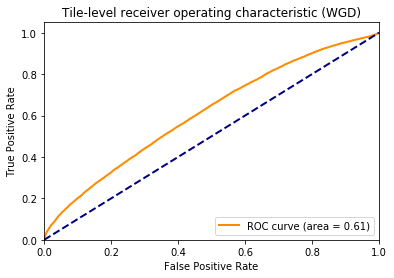

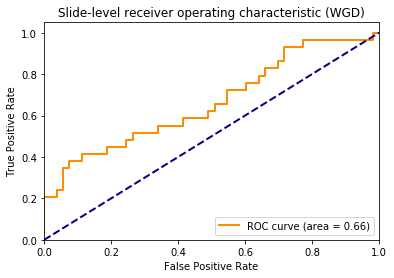

In [12]:
get_results_and_curves(e, dataset, task, pickle_file, state_dict_file, root_dir, transform, 
                       batch_size, n_workers, output_shape, criterion, device)

In [13]:
task = 'MSI-SINGLE_LABEL'
pickle_file = '/n/tcga_models/resnet18_MSI_singlelabel_v02_sa.pkl'
state_dict_file = '/n/tcga_models/resnet18_MSI_singlelabel_v02.pt'

Epoch: 0, Batch: 0, Val NLL: 2.0527
Epoch: 0, Batch: 100, Val NLL: 1.0325
Epoch: 0, Avg Val NLL: 0.8339, Median Val NLL: 0.6193
------ Val Tile-Level Acc: 0.5491; By Label: 0: 0.6631, 1: 0.3921
------ Val Slide-Level Acc: Mean-Pooling: 0.5972, Max-Pooling: 0.4306
------ Val Slide-Level Acc (Mean-Pooling) By Label: 0: 0.8048, 1: 0.3225


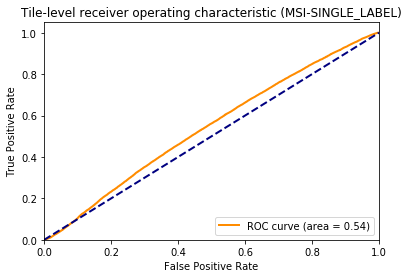

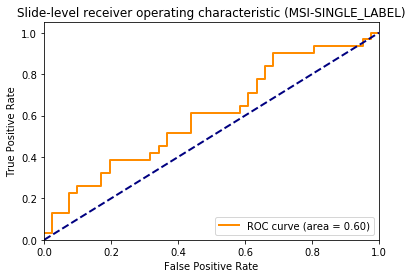

In [14]:
get_results_and_curves(e, dataset, task, pickle_file, state_dict_file, root_dir, transform, 
                       batch_size, n_workers, output_shape, criterion, device)